In [2]:
!pip install pyitlib
!pip install lime
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyitlib: filename=pyitlib-0.2.2-py3-none-any.whl size=28501 sha256=1d45ae884223131e926eaa508b0b973506fd69cc518245287329fccc23fc13b1
  Stored in directory: /root/.cache/pip/wheels/14/96/d6/86e32d66e5bb0440dc344e75849266b2bf2939520672e33e4e
Successfully built pyitlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 29.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=d2de8ec119961d62a5e85f807ce9119942334b0c0173c9299e8929872e0f1d39
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 33.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import class_weight, resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn. svm import SVC 
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from matplotlib import pyplot as plt
from scipy import stats
from pyitlib import discrete_random_variable as drv
from google.colab import drive
import seaborn as sns
import math
import lime
import lime.lime_tabular
import shap
import xgboost as xgb
import matplotlib.colors as colors

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# df = pd.read_csv("card_transdata.csv")
df = pd.read_csv('gdrive/My Drive/card_transdata.csv')
df.describe()

distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%                          0.997717         1.000000        0.000000   
75%                          2.096370         1.000000        1.000000   
max                        267.802942         1.000000        1.000000   

       used_pin_number    online_order           fraud  
count   1000000.000000  1000000.000000  1000000.000000  
mean          0.100608        0.650552        0.087403  
std           0.300809        0.476796        0.282425  
min           0.000000        0.000000        0.000000  
25%           0.000000        0.000000        0.000000  
50%           0.000000        1.000000        0.000000  
75%           0.000000        1.000000        0.000000  
max           1.000000        1.000000        1.000000

In [ ]:
#data type for variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [ ]:
#check if there is any missing data
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### EXPLORATORY DATA ANALYSIS

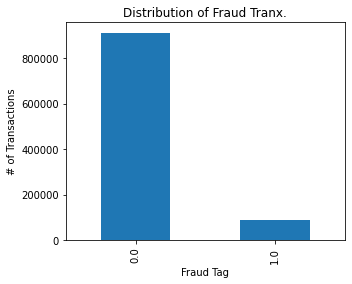

In [ ]:
# count of fraud vs not fraud
plt.figure(figsize=(5, 4))
df['fraud'].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud Tranx.')
plt.xlabel('Fraud Tag')
plt.ylabel('# of Transactions')
plt.show()

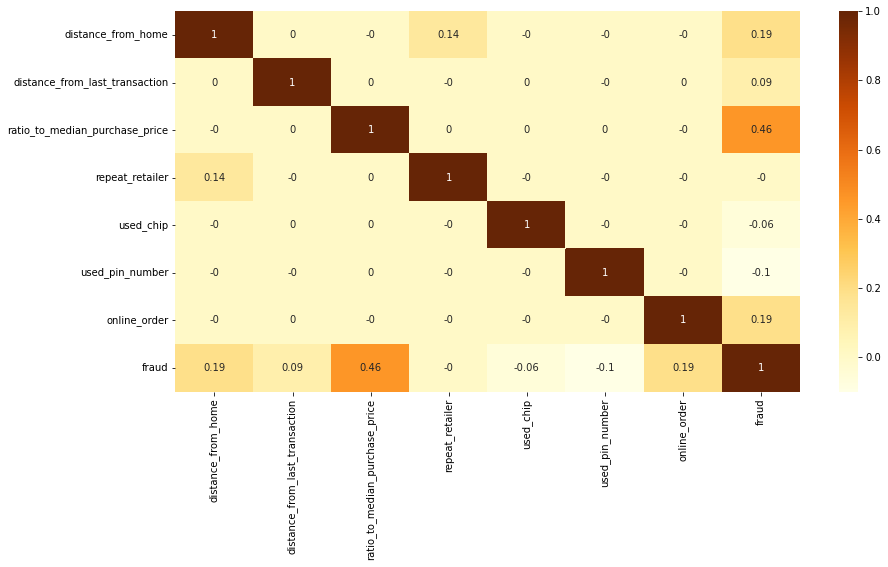

In [ ]:
#BIVARIATE ANALYSIS
#correlation heatmap
correlation = df.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')

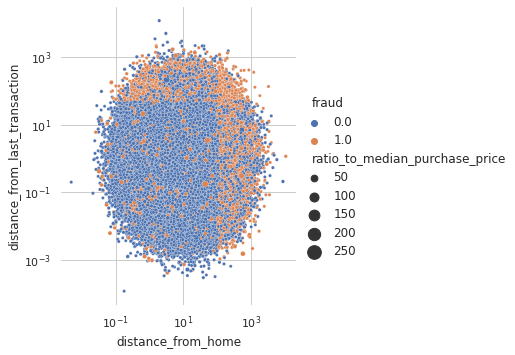

In [ ]:
# scatterplot of distance_from_home against distance_from_last_transaction
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df,
    x='distance_from_home', y='distance_from_last_transaction',
    hue='fraud', size='ratio_to_median_purchase_price',
    sizes=(10, 200),
)
g.set(xscale='log', yscale='log')
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
sns.reset_orig()

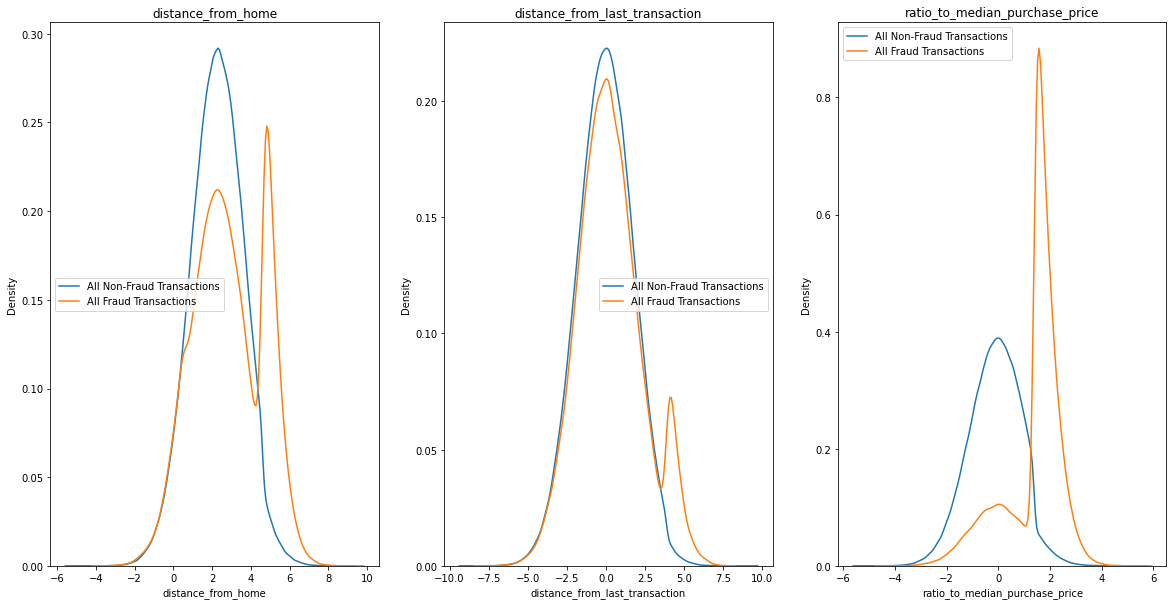

In [ ]:
#kurtosis plot
f, axes = plt.subplots(1, 3, figsize=(20, 10))
numerical_variables = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
for variable in numerical_variables:
  df[variable] = df[variable].map(lambda x: math.log(x))
for index, variable in enumerate(numerical_variables):
  sns.kdeplot(df[df['fraud']==0][variable], ax=axes[index])
  sns.kdeplot(df[df['fraud'] == 1][variable], ax=axes[index])
  axes[index].set_title(variable)
  axes[index].legend(['All Non-Fraud Transactions', 'All Fraud Transactions'])

### DATA PREPROCESSING FOR SUPPORT VECTOR MACHINE

In [ ]:
df = pd.read_csv('gdrive/My Drive/card_transdata.csv')
#down sampling
fraud_df = df[df['fraud']==1]
non_fraud_df = df[df['fraud']==0]
downsampled_fraud_df = resample(fraud_df, replace  = False, n_samples = 5000, random_state = 42)
downsampled_nonfraud_df = resample(non_fraud_df, replace  = False, n_samples = 5000, random_state = 42)
#merge back the 2 downsampled dataframes
downsampled_df = pd.concat([downsampled_fraud_df, downsampled_nonfraud_df])
# print(len(downsampled_df))

#Independant variables 
X = downsampled_df.drop('fraud', axis=1).copy()
y = downsampled_df['fraud'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=25)

# x_train = scale(x_train)
# x_test = scale(x_test)
# x_train[0]

x_cols = x_train.columns.values.tolist()
#SCALING
scaler = StandardScaler() 
# scaler = MinMaxScaler() 
#scale x_train
# scaled_data_x_train = scaler.fit_transform(x_train)
# x_train = pd.DataFrame(scaled_data_x_train, columns=x_cols)


col_names = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] 
x_train[col_names] = scaler.fit_transform(x_train[col_names])
# x_train.head()

##scale x_test
# scaled_data_x_test = scaler.fit_transform(x_test)
# x_test = pd.DataFrame(scaled_data_x_test, columns=x_cols)
# x_test.head()
x_test[col_names] = scaler.fit_transform(x_test[col_names])
x_test.head()

# svc_test_df = x_test.copy()
# svc_test_df['fraud'] = y_test.copy()
# svc_test_df.head()

distance_from_home  distance_from_last_transaction  \
68266             0.597384                        0.326845   
880429           -0.436826                       -0.059612   
160915           -0.463435                       -0.288030   
86828            -0.260298                       -0.217922   
452868           -0.349236                       -0.167687   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
68266                        -0.604148              1.0        0.0   
880429                        0.140217              1.0        0.0   
160915                       -0.480391              0.0        0.0   
86828                        -0.655170              1.0        1.0   
452868                       -0.720023              1.0        1.0   

        used_pin_number  online_order  
68266               0.0           1.0  
880429              0.0           1.0  
160915              0.0           1.0  
86828               0.0           0.0  
452868              0.0           0.0

CROSS VALIDATION

In [ ]:
%%time
parameter_values = [
    {'C': [0.5, 1, 10, 100],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']
     }, 
]

best_parameters = GridSearchCV(SVC(), parameter_values, cv = 5, scoring = 'recall', verbose = 0)

best_parameters.fit(x_train, y_train)
print(f"optimal parameters : {best_parameters.best_params_}")

optimal parameters : {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
CPU times: user 1min 41s, sys: 643 ms, total: 1min 42s
Wall time: 1min 44s


### EVALUATION FUNCTION

In [ ]:
from sklearn.metrics import classification_report # for model evaluation metrics
def fitting(x_train, x_test, y_train, y_test, C, gamma, kernel):
    # Create training and testing samples
    X_train = x_train
    X_test = x_test 
    y_train = y_train 
    y_test = y_test
    

    # Fit the model
    # Note, available kernels: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
    model = SVC(kernel=kernel, C=C, gamma=gamma)
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Use score method to get accuracy of the model
    print('----- Evaluation on Test Data -----')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te, digits=6))
    print('--------------------------------------------------------')

    print('----- Evaluation on Training Data -----')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr, digits=6))
    print('--------------------------------------------------------')
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf

### OPTIMIZED SVC

In [ ]:
X_train, X_test, y_train, y_test, clf = fitting(x_train, x_test, y_train, y_test, 0.5, 1, 'rbf')

----- Evaluation on Test Data -----
Accuracy Score:  0.9764
              precision    recall  f1-score   support

         0.0   0.998344  0.954869  0.976123      1263
         1.0   0.955882  0.998383  0.976671      1237

    accuracy                       0.976400      2500
   macro avg   0.977113  0.976626  0.976397      2500
weighted avg   0.977334  0.976400  0.976394      2500

--------------------------------------------------------
----- Evaluation on Training Data -----
Accuracy Score:  0.9878666666666667
              precision    recall  f1-score   support

         0.0   1.000000  0.975649  0.987674      3737
         1.0   0.976388  1.000000  0.988053      3763

    accuracy                       0.987867      7500
   macro avg   0.988194  0.987824  0.987864      7500
weighted avg   0.988153  0.987867  0.987864      7500

--------------------------------------------------------


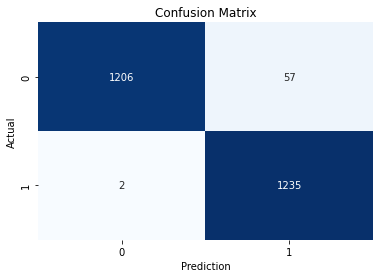

CPU times: user 595 ms, sys: 71.6 ms, total: 666 ms
Wall time: 582 ms


In [ ]:
%%time
# plot_confusion_matrix(svm_model, x_test, y_test, values_format='d', display_labels=['non-fraud', 'fraud'])
svm_model = SVC(C = 0.5, gamma = 1, kernel = 'rbf')
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
svc_cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(svc_cm, annot=True, cbar=False, cmap='Blues', fmt = 'g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

### DEFAULT SVC

In [ ]:
X_train, X_test, y_train, y_test, clf = fitting(x_train, x_test, y_train, y_test, 1.0, 'scale', 'rbf')

----- Evaluation on Test Data -----
Accuracy Score:  0.974
              precision    recall  f1-score   support

         0.0   0.995861  0.952494  0.973695      1263
         1.0   0.953560  0.995958  0.974298      1237

    accuracy                       0.974000      2500
   macro avg   0.974711  0.974226  0.973997      2500
weighted avg   0.974931  0.974000  0.973993      2500

--------------------------------------------------------
----- Evaluation on Training Data -----
Accuracy Score:  0.9818666666666667
              precision    recall  f1-score   support

         0.0   0.997238  0.966283  0.981517      3737
         1.0   0.967517  0.997343  0.982204      3763

    accuracy                       0.981867      7500
   macro avg   0.982378  0.981813  0.981860      7500
weighted avg   0.982326  0.981867  0.981861      7500

--------------------------------------------------------


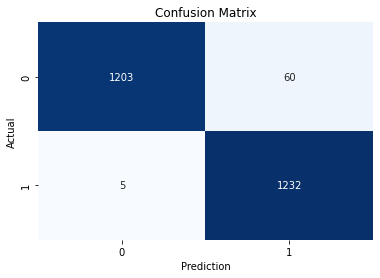

CPU times: user 672 ms, sys: 80.4 ms, total: 753 ms
Wall time: 664 ms


In [ ]:
%%time
# plot_confusion_matrix
default_svm_model = SVC()
default_svm_model.fit(x_train, y_train)
default_y_pred = default_svm_model.predict(x_test)
svc_cm = confusion_matrix(y_test, default_y_pred)
ax = sns.heatmap(svc_cm, annot=True, cbar=False, cmap='Blues', fmt = 'g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

### PRINCIPAL COMPONENT ANALYSIS TO APPROXIMATE 2D DECISION BOUNDARY OF SVC



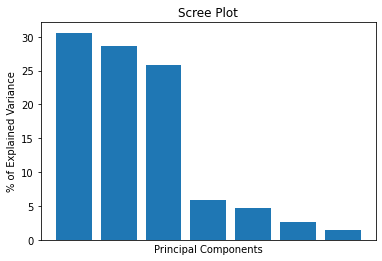

In [ ]:
#visualise % of variance of each principal component
pca = PCA()
x_train_pca = pca.fit_transform(x_train)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
)
plt.ylabel('% of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [ ]:
#preparing new dataset for pca1 and pca2
train_pc1_coords = x_train_pca[:, 0]
train_pc2_coords = x_train_pca[:, 1]
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
#cross validation to find optimal hyperparameters of new dataset consisting of only PC1 and PC2
# print(pca_train_scaled)

In [ ]:
%%time
#cross validation to find optimal hyperparameters of new dataset consisting of only PC1 and PC2
# print(pca_train_scaled)

parameter_values = [
    {'C': [0.5, 1, 10, 100],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']
     }, 
]

best_parameters = GridSearchCV(SVC(), parameter_values, cv = 5, scoring = 'recall', verbose = 0)

best_parameters.fit(pca_train_scaled, y_train)
print(f"optimal parameters : {best_parameters.best_params_}")

optimal parameters : {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
CPU times: user 2min 59s, sys: 1.54 s, total: 3min
Wall time: 3min 1s


Text(0, 0, 'fraud')


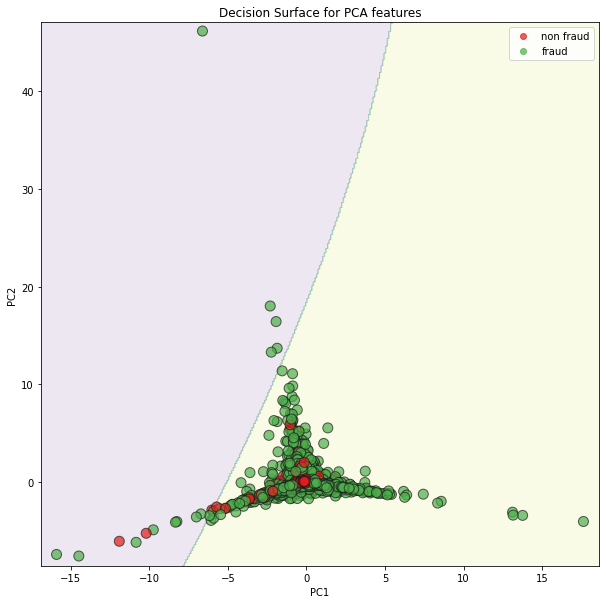

In [ ]:
#approximate decision boundary 
train_pc1_coords = x_train_pca[:, 0]
train_pc2_coords = x_train_pca[:, 1]
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
pca_svm = SVC(random_state = 0, C=0.5, gamma=0.0001, kernel='rbf')
pca_svm.fit(pca_train_scaled, y_train)
x_test_pca = pca.transform(x_train)

test_pc1_coords = x_test_pca[:, 0]
test_pc2_coords = x_test_pca[:, 1]

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

z = pca_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
z = z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, cmap=cmap, s=100, edgecolors='k', alpha=0.7)
legend = ax.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc='upper right')
legend.get_texts()[0].set_text('non fraud')
legend.get_texts()[1].set_text('fraud')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision Surface for PCA features')
print(legend.get_texts()[1])
# plt.show()

### DATA PREPROCESSING FOR KNN, RANDOM FOREST, XGBOOST AND NEURAL NETWORKS

In [8]:
# DATA PREPROCESSING
# downsampling to balance non-fraud and fraud classes
fraud_df = df[df['fraud']==1]
non_fraud_df = df[df['fraud']==0]
downsampled_nonfraud_df = resample(non_fraud_df, replace  = False, n_samples = len(fraud_df), random_state = 1)
# merge back the 2 downsampled dataframes
downsampled_df = pd.concat([fraud_df, downsampled_nonfraud_df])

# Independant variables 
X = downsampled_df.drop('fraud', axis=1).copy()
y = downsampled_df['fraud'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1)

# UNSCALED TRAIN DATA (for RandomForest and XGBoost)
train_df = x_train.copy()
train_df['fraud'] = y_train.tolist()

# UNSCALED TEST DATA (for RandomForest and XGBoost)
test_df = x_test.copy()
test_df['fraud'] = y_test.tolist()

# SCALED TRAIN DATA (for KNN and MLP)
x_cols = x_train.columns.values.tolist()
scaler = StandardScaler()
col_names = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] 
continuous_features = df[col_names]
x_train_scaled = x_train.copy()
x_train_scaled[col_names] = scaler.fit_transform(x_train[col_names])
train_df_scaled = pd.DataFrame(x_train_scaled, columns=x_cols)
train_df_scaled['fraud'] = y_train.tolist()

# SCALED TEST DATA (for KNN and MLP)
continuous_features = df[col_names]
df[col_names] = scaler.fit_transform(continuous_features)
x_test_scaled = x_test.copy()
x_test_scaled[col_names] = scaler.fit_transform(x_test[col_names])
test_df_scaled = pd.DataFrame(x_test_scaled, columns=x_cols)
test_df_scaled['fraud'] = y_test.tolist()

### KNN MODEL

In [ ]:
# KNN model iteration to find optimal number of neighbours
train_accuracy = []
test_accuracy = []
sse_list = []

for k in range(2, 10):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(x_train_scaled, y_train)
  y_pred = knn.predict(x_test_scaled)
  train_accuracy.append(knn.score(x_train_scaled, y_train))
  test_accuracy.append(knn.score(x_test_scaled, y_test))

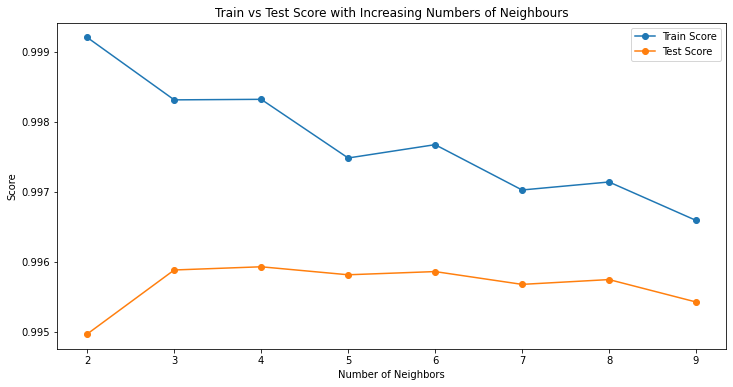

In [ ]:
plt.figure(figsize = (12, 6))

plt.plot(range(2, 10), train_accuracy, label = "Train Score",
         marker = "o")

plt.plot(range(2, 10), test_accuracy, label = "Test Score", 
         marker = "o")

plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.title("Train vs Test Score with Increasing Numbers of Neighbours")
plt.legend()
plt.show()

In [ ]:
# KNN model with 4 neighbours
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train_scaled, y_train)
y_pred = knn.predict(x_test_scaled)

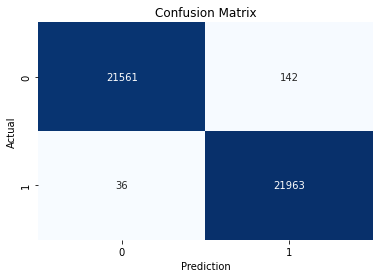

              precision    recall  f1-score   support

         0.0   0.998333  0.993457  0.995889     21703
         1.0   0.993576  0.998364  0.995964     21999

    accuracy                       0.995927     43702
   macro avg   0.995955  0.995910  0.995927     43702
weighted avg   0.995938  0.995927  0.995927     43702



In [ ]:
# KNN model with 4 neighbours performance
knn_cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(knn_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, digits=6))

In [ ]:
# KNN model with 4 neighbours and weights
knn = KNeighborsClassifier(n_neighbors = 4, weights='distance')
knn.fit(x_train_scaled, y_train)
y_pred = knn.predict(x_test_scaled)

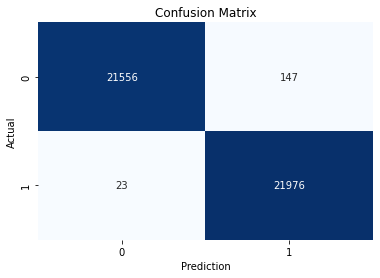

              precision    recall  f1-score   support

         0.0   0.998934  0.993227  0.996072     21703
         1.0   0.993355  0.998954  0.996147     21999

    accuracy                       0.996110     43702
   macro avg   0.996145  0.996091  0.996110     43702
weighted avg   0.996126  0.996110  0.996110     43702



In [ ]:
# KNN model with 4 neighbours and weights performance
knn_cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(knn_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, digits=6))

### RANDOM FOREST

In [7]:
# random forest with 100 n_estimators (default)
rf_100 = RandomForestClassifier(random_state=1)
rf_100.fit(x_train.values, y_train.to_numpy())
rf_100_pred = rf_100.predict(x_test.values)

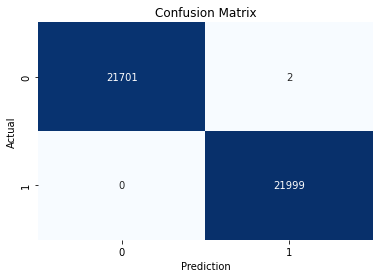

              precision    recall  f1-score   support

         0.0   1.000000  0.999908  0.999954     21703
         1.0   0.999909  1.000000  0.999955     21999

    accuracy                       0.999954     43702
   macro avg   0.999955  0.999954  0.999954     43702
weighted avg   0.999954  0.999954  0.999954     43702



In [8]:
# performance of random forest with 100 n_estimators
rf_100_cm = confusion_matrix(y_test.to_numpy(), rf_100_pred)
ax = sns.heatmap(rf_100_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
print(classification_report(y_test, rf_100_pred, digits=6))

In [ ]:
# Using GridSearchCV for hyperparameter tuning
# Define the parameter sets to test
param_grid = {'n_estimators': [10, 90],
              'max_features': ['auto', 'log2'], 
              'max_depth': [2, 4, 6, 8, 10],
              'criterion': ['gini', 'entropy']}

rf_model = RandomForestClassifier(random_state=1)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)
CV_model.fit(x_train.values, y_train.to_numpy())
CV_pred = CV_model.predict(x_test.values)
print('Best params: ', CV_model.best_params_)

Best params:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 90}


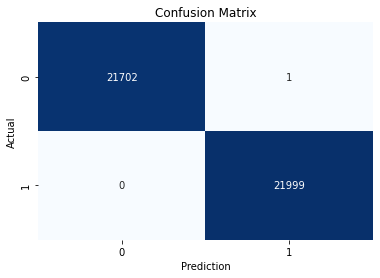

              precision    recall  f1-score   support

         0.0   1.000000  0.999954  0.999977     21703
         1.0   0.999955  1.000000  0.999977     21999

    accuracy                       0.999977     43702
   macro avg   0.999977  0.999977  0.999977     43702
weighted avg   0.999977  0.999977  0.999977     43702



In [ ]:
# performance of random forest using GridSearchCV
CV_cm = confusion_matrix(y_test.to_numpy(), CV_pred)
ax = sns.heatmap(CV_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
print(classification_report(y_test, CV_pred, digits=6))

In [9]:
# hyperparameter tuning using RandomizedSearch
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_model = RandomForestClassifier(random_state=1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomized = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)# Fit the random search model
rf_randomized.fit(x_train.values, y_train.to_numpy())
print('Best params: ', rf_randomized.best_params_)
rf_randomized_pred = rf_randomized.predict(x_test.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


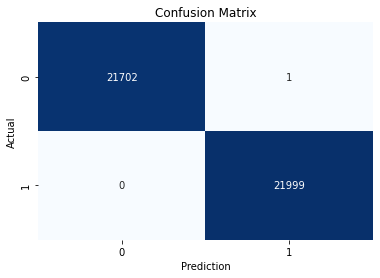

              precision    recall  f1-score   support

         0.0   1.000000  0.999954  0.999977     21703
         1.0   0.999955  1.000000  0.999977     21999

    accuracy                       0.999977     43702
   macro avg   0.999977  0.999977  0.999977     43702
weighted avg   0.999977  0.999977  0.999977     43702



In [10]:
# performance of random forest using RandomizedSearchCV
rf_randomized_cm = confusion_matrix(y_test.to_numpy(), rf_randomized_pred)
ax = sns.heatmap(rf_randomized_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
print(classification_report(y_test, rf_randomized_pred, digits=6))

### LIME to explain Random Forest

In [11]:
# using LIME to explain RF model
new_x_cols = ['dist_home', 'dist_trans', 'ratio_median', 'repeat_retailer', 'used_chip', 'used_pin', 'online_order', 'fraud']
predict_fn_rf = lambda x: rf_randomized.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names = new_x_cols, class_names=['Not Fraud','Fraud'], kernel_width=5)

In [12]:
test_df.head()

distance_from_home  distance_from_last_transaction  \
985779            0.492074                        2.374592   
738377           30.215822                        0.406742   
882426            8.950742                        2.133920   
787107          170.936754                        1.718058   
880136           31.330418                        6.611863   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
985779                        0.357316              0.0        0.0   
738377                        1.440366              1.0        0.0   
882426                        1.064110              1.0        0.0   
787107                       10.526312              1.0        0.0   
880136                       10.317532              1.0        1.0   

        used_pin_number  online_order  fraud  
985779              0.0           1.0    0.0  
738377              0.0           1.0    0.0  
882426              0.0           1.0    0.0  
787107              0.0           1.0    1.0  
880136              0.0           1.0    1.0

In [13]:
chosen_instance1 = x_test.loc[[985779]].values[0]
exp = explainer.explain_instance(chosen_instance1, predict_fn_rf, num_features=7)
exp.show_in_notebook(show_all=False)

In [14]:
chosen_instance2 = x_test.loc[[787107]].values[0]
exp = explainer.explain_instance(chosen_instance2, predict_fn_rf, num_features=7)
exp.show_in_notebook(show_all=False)

In [15]:
chosen_instance3 = x_test.loc[[880136]].values[0]
exp = explainer.explain_instance(chosen_instance3, predict_fn_rf, num_features=7)
exp.show_in_notebook(show_all=False)

### XGBoost

In [21]:
# XGBoost model
#XGBoost
xgbc = xgb.XGBClassifier()
xgbc.fit(x_train,y_train)
y_pred_xgb = xgbc.predict(x_test)

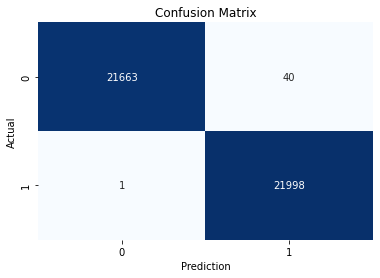

              precision    recall  f1-score   support

         0.0   0.999954  0.998157  0.999055     21703
         1.0   0.998185  0.999955  0.999069     21999

    accuracy                       0.999062     43702
   macro avg   0.999069  0.999056  0.999062     43702
weighted avg   0.999063  0.999062  0.999062     43702



In [22]:
# XGBoost performance
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
ax = sns.heatmap(xgb_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_xgb, digits=6))

In [9]:
# GridSearch for XGBoost hyper parameter tuning
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}


In [10]:
# XGBoost model with hyperparameter tuning from GridSearch
xgbc = xgb.XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth= 6, n_estimators=1000)
xgbc.fit(x_train,y_train)
y_pred_xgb = xgbc.predict(x_test)

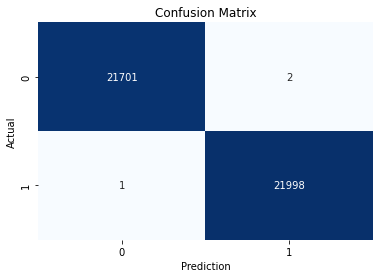

              precision    recall  f1-score   support

         0.0   0.999954  0.999908  0.999931     21703
         1.0   0.999909  0.999955  0.999932     21999

    accuracy                       0.999931     43702
   macro avg   0.999932  0.999931  0.999931     43702
weighted avg   0.999931  0.999931  0.999931     43702



In [11]:
# XGBoost performance
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
ax = sns.heatmap(xgb_cm, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_xgb, digits=6))



### SHAP to explain XGBoost

In [12]:
shap.initjs()
shap_xgbc = shap.TreeExplainer(xgbc)
shapvals_xgbc = shap_xgbc.shap_values(x_test)

# visualize the first prediction's explanation
shap.force_plot(shap_xgbc.expected_value, shapvals_xgbc[0,:], x_test.iloc[0,:], link='logit')

In [13]:
# visualize first 1000 predictions
shap.initjs()
shap.force_plot(shap_xgbc.expected_value, shapvals_xgbc[:1000,:], x_test.iloc[:1000,:], link='logit')

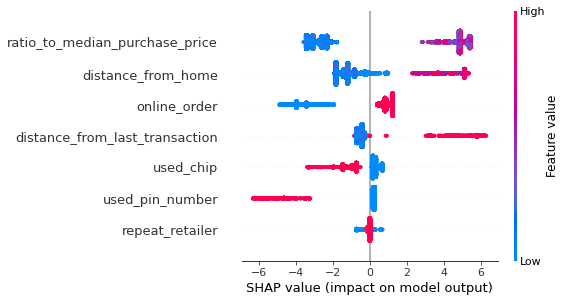

In [14]:
# summarize the effects of all the features
shap.summary_plot(shapvals_xgbc, x_test)

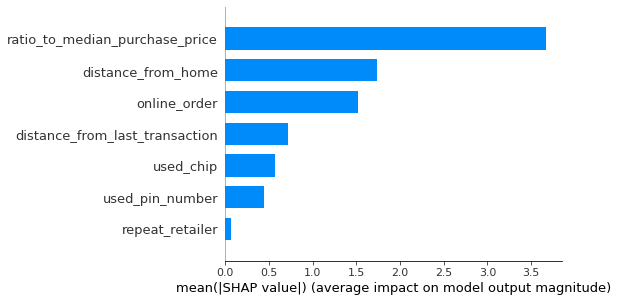

In [15]:
shap.summary_plot(shapvals_xgbc, x_test, plot_type="bar")

### Neural Network

In [16]:
# number of hidden nodes
H = 64
# input dimension
input_dim = 1
# num of epochs
num_epochs = 20

# create sequential multi-layer perceptron
model3 = Sequential()
# layer 0
model3.add(Flatten())
model3.add(Dense(units = H, activation='ReLU', input_shape=(input_dim,)))

# layer 1
model3.add(Dense(units = H, activation='ReLU'))

# layer 2
model3.add(Dense(units = H, activation='ReLU'))

# layer 3
model3.add(Dense(units = H, activation='ReLU'))

# layer 4
model3.add(Dense(units = H, activation='ReLU'))

# layer 5
model3.add(Dense(units = H, activation='ReLU'))

# layer 6
model3.add(Dense(units = 1, activation='sigmoid'))
# configure the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# fit the model 
model_history3 = model3.fit(x_train_scaled, y_train, batch_size=50, epochs=num_epochs, verbose=0)

train_score = model3.evaluate(x_train_scaled, y_train, verbose=0)
print('Train loss:', train_score)
print('Train R2:', r2(y_train, model3.predict(x_train_scaled)))

test_score = model3.evaluate(x_test_scaled, y_test, verbose=0)
print('Test loss:', test_score)
print('Test R2:', r2(y_test, model3.predict(x_test_scaled)))

Train loss: [0.003646817756816745, 0.9984287023544312]
4097/4097 [==============================] - 8s 2ms/step
Train R2: 0.9955487551599473
Test loss: [0.010893531143665314, 0.9974142909049988]
1366/1366 [==============================] - 2s 1ms/step
Test R2: 0.9915587995923968


In [17]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4

1366/1366 [==============================] - 2s 2ms/step


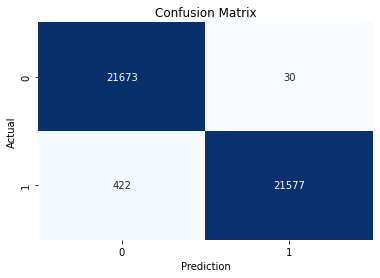

In [18]:
threshold = 0.995
y_preds=model3.predict(x_test_scaled)
# print(y_preds)
y_pred = np.where(y_preds > threshold, 1,0)
c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

         0.0   0.980901  0.998618  0.989680     21703
         1.0   0.998612  0.980817  0.989634     21999

    accuracy                       0.989657     43702
   macro avg   0.989756  0.989718  0.989657     43702
weighted avg   0.989816  0.989657  0.989657     43702



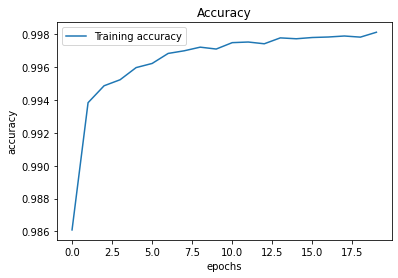

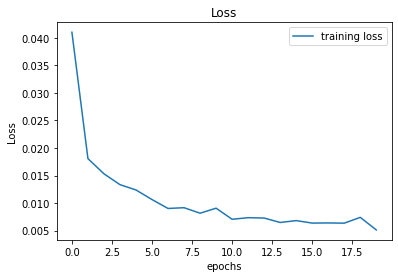

In [20]:
plt.figure(0)
plt.plot(model_history3.history['accuracy'], label="Training accuracy")
# plt.plot(model_history3.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(model_history3.history['loss'], label="training loss")
# plt.plot(model_history3.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()